# PSANN Research Colab -- GPU-Ready, Paper-Prep Pipeline

**Date:** 2025-10-15

This notebook is a one-stop pipeline to generate figures, tables, and diagnostics for a paper on **Parameterized Sine-Activated Neural Networks (PSANN)** and episodic optimisation via **HISSO**.

What you'll get out of a single run:
- Supervised baselines on synthetic regression (to sanity-check training and GPU).
- HISSO episodic optimisation on synthetic series and real-market crypto data (optional) with finance reward.
- Ablations: residual vs. plain, optional LSM preprocessor (best-effort -- guarded by `try/except` in case your local API differs).
- Streaming/online predictions (state controller helpers).
- Spectral/geometry diagnostics (Jacobian spectrum, NTK eigenvalues, participation ratio).
- Reproducible artifacts: JSON/CSV logs and publication-ready figures in a timestamped results directory.

**Tip:** Set Colab runtime to **GPU** (`Runtime -> Change runtime type -> GPU`).

---

> API hooks used here follow the up-to-date PSANN docs (sine activation, shared fit pipeline, `HISSOOptions`, reward registry, streaming helpers, and utils for diagnostics). For details see the project README and technical notes you'll have locally.

## 0) Configuration & Installation
Choose how to install **psann** in this environment. Three options:
- **PyPI**: if you have published the package.
- **Git URL**: a public/private repo URL (use a GitHub token in the URL if needed).
- **Local path (Drive)**: mount Google Drive and point to a local folder; editable install.

> If the install path differs in your tree, just tweak the variables and re-run the cell.

In [ ]:
#@title Install: pick source for `psann` and minimal deps
USE_PYPI = True  #@param {type:"boolean"}
PSANN_GIT_URL = ""  #@param {type:"string"}
LOCAL_PATH = ""  #@param {type:"string"}
EXTRAS = "sklearn,viz"  #@param {type:"string"}

import os, sys, subprocess, pkgutil, json

def pip_install(args):
    print(">>> pip install", " ".join(args))
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + args)

# Always upgrade pip & core deps we rely on in notebooks
pip_install(["--upgrade", "pip", "setuptools", "wheel"])

# Data/plotting helpers
pip_install(["numpy", "pandas", "matplotlib", "scikit-learn", "tqdm"])

# Optional market-data (only used if you enable the real-crypto section)
try:
    import yfinance  # noqa
except Exception:
    pip_install(["yfinance"])

# Install psann
installed = False
if USE_PYPI:
    try:
        pip_install([f"psann[{EXTRAS}]"])
        installed = True
    except subprocess.CalledProcessError as e:
        print("PyPI install failed, will try other sources if provided.", e)

if (not installed) and PSANN_GIT_URL:
    pip_install([f"git+{PSANN_GIT_URL}#egg=psann[{EXTRAS}]"])
    installed = True

if (not installed) and LOCAL_PATH:
    pip_install(["-e", LOCAL_PATH])
    installed = True

if not installed:
    print(">>> Unable to install psann automatically. "
          "Set USE_PYPI=True, or provide PSANN_GIT_URL, or set LOCAL_PATH to a valid package dir.")
else:
    import psann  # Should import after install
    print("PSANN imported from:", psann.__file__)

>>> pip install --upgrade pip setuptools wheel
>>> pip install numpy pandas matplotlib scikit-learn tqdm
>>> pip install psann[sklearn,viz]
PSANN imported from: /usr/local/lib/python3.12/dist-packages/psann/__init__.py


## 1) Environment snapshot
Confirm GPU, CUDA, PyTorch, and `psann` versions. This is important for reproducibility.

In [ ]:
import json, platform, sys, subprocess, os, time

def run(cmd):
    try:
        out = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT, text=True)
        print(out)
    except subprocess.CalledProcessError as e:
        print(e.output)

try:
    import torch
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU device:", torch.cuda.get_device_name(0))
        print("CUDA capability:", torch.cuda.get_device_capability(0))
except Exception as e:
    print("Torch not available:", e)

try:
    import psann
    print("psann version/module:", getattr(psann, "__version__", "n/a"), psann.__file__)
except Exception as e:
    print("psann import failed:", e)

print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("Time:", time.ctime())

print("\nNVIDIA SMI (if present):")
run("nvidia-smi || true")

PyTorch version: 2.8.0+cu126
CUDA available: False
psann version/module: 0.10.01 /usr/local/lib/python3.12/dist-packages/psann/__init__.py
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Time: Wed Oct 15 09:28:26 2025

NVIDIA SMI (if present):
/bin/sh: 1: nvidia-smi: not found



## 2) Reproducibility & paths
Set seeds and prepare a timestamped results directory to collect **figures** and **logs**.

In [ ]:
#@title Seeds and directories
from datetime import datetime
import random, numpy as np, os, json

RUN_TAG = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
BASE_DIR = f"/content/psann_paper_{RUN_TAG}"
FIG_DIR = os.path.join(BASE_DIR, "figs")
LOG_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

SEED = 1337  #@param {type:"integer"}
FAST_MODE = True  #@param {type:"boolean"}

def seed_all(seed):
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(SEED)

print("Results root:", BASE_DIR)

Results root: /content/psann_paper_20251015_092826


/tmp/ipython-input-476979564.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_TAG = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


## 3) Helper utilities
Lightweight logging and plotting helpers. The charts follow a simple rule for publication: **matplotlib only**, one chart per figure, default colors.

In [ ]:
import os, json, numpy as np, matplotlib.pyplot as plt, pandas as pd
from typing import Dict, Any

def save_json(path, data: Dict[str, Any]):
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    return path

def save_csv(path, df: pd.DataFrame):
    df.to_csv(path, index=False)
    return path

def fig_save(path, dpi=150):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print("Saved figure to", path)

def sharpe(returns, eps=1e-8):
    r = np.array(returns).astype(np.float64)
    if r.size < 2:
        return float("nan")
    mean = r.mean()
    std = r.std() + eps
    return float(mean / std)

def to_device(x):
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.tensor(x).to(device)

## 4) Supervised regression baseline (sanity check)
We fit `PSANNRegressor` on a smooth nonlinear function to confirm training, scoring, and plotting all work as expected.

Epoch 1/60 - loss: 0.137441
Epoch 2/60 - loss: 0.136980
Epoch 3/60 - loss: 0.136873
Epoch 4/60 - loss: 0.136871
Epoch 5/60 - loss: 0.136986
Epoch 6/60 - loss: 0.136822
Epoch 7/60 - loss: 0.136805
Epoch 8/60 - loss: 0.136869
Epoch 9/60 - loss: 0.136817
Epoch 10/60 - loss: 0.136782
Epoch 11/60 - loss: 0.136809
Epoch 12/60 - loss: 0.136765
Epoch 13/60 - loss: 0.136805
Epoch 14/60 - loss: 0.136897
Epoch 15/60 - loss: 0.136862
Epoch 16/60 - loss: 0.136832
Epoch 17/60 - loss: 0.136735
Epoch 18/60 - loss: 0.136723
Epoch 19/60 - loss: 0.136722
Epoch 20/60 - loss: 0.136729
Epoch 21/60 - loss: 0.136792
Epoch 22/60 - loss: 0.136698
Epoch 23/60 - loss: 0.136732
Epoch 24/60 - loss: 0.136749
Epoch 25/60 - loss: 0.136643
Epoch 26/60 - loss: 0.136714
Epoch 27/60 - loss: 0.136638
Epoch 28/60 - loss: 0.136623
Epoch 29/60 - loss: 0.136581
Epoch 30/60 - loss: 0.136572
Epoch 31/60 - loss: 0.136698
Epoch 32/60 - loss: 0.136474
Epoch 33/60 - loss: 0.136459
Epoch 34/60 - loss: 0.136545
Epoch 35/60 - loss: 0.1

'/content/psann_paper_20251015_092826/logs/supervised_metrics.json'

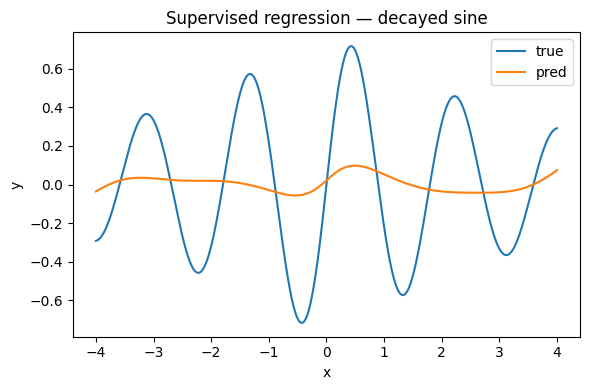

In [ ]:
#@title Supervised baseline on synthetic regression
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from psann import PSANNRegressor

# Synthetic function: exp-decayed sine
n = 4000 if not FAST_MODE else 1000
rs = np.random.RandomState(SEED)
X = np.linspace(-4, 4, n, dtype=np.float32).reshape(-1, 1)
y = 0.8 * np.exp(-0.25 * np.abs(X)) * np.sin(3.5 * X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

model = PSANNRegressor(
    hidden_layers=2,
    hidden_units=64,
    epochs=200 if not FAST_MODE else 60,
    batch_size=128,
    lr=1e-3,
    early_stopping=True,
    patience=20,
    random_state=SEED,
)
model.fit(X_train, y_train, verbose=1)
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print("R^2 train:", r2_train, "R^2 test:", r2_test)

# Plot predictions vs ground truth on the full grid
y_hat = model.predict(X)
plt.figure(figsize=(6, 4))
plt.plot(X[:,0], y, label="true")
plt.plot(X[:,0], y_hat, label="pred")
plt.title("Supervised regression -- decayed sine")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
fig_save(os.path.join(FIG_DIR, "supervised_regression.png"))

save_json(os.path.join(LOG_DIR, "supervised_metrics.json"), {
    "r2_train": float(r2_train),
    "r2_test": float(r2_test),
    "n_samples": int(n),
})

## 5) HISSO episodic optimisation on synthetic series
We simulate a multi-asset return series and train with the built-in **finance** reward. We keep a supervised warm start optional.

In [ ]:
# === Robust HISSO run cell (full replacement) ===
import os, inspect, json, numpy as np, matplotlib.pyplot as plt

# Lightweight helpers (define if missing from earlier cells)
try:
    fig_save
except NameError:
    def fig_save(path, dpi=150):
        plt.tight_layout()
        plt.savefig(path, dpi=dpi, bbox_inches="tight")
        print("Saved figure to", path)

try:
    save_json
except NameError:
    def save_json(path, data):
        with open(path, "w") as f:
            json.dump(data, f, indent=2)
        print("Saved json to", path)

# 0) Try to import torch
try:
    import torch
except Exception as e:
    raise RuntimeError("Torch is required for HISSO training. Install PyTorch in this environment.") from e

# 1) Robust psann imports (try several common locations)
PSANNRegressor = None
get_reward_strategy = None
HISSOOptions = None

try:
    from psann import PSANNRegressor, get_reward_strategy, HISSOOptions
    print("Imported PSANNRegressor, get_reward_strategy, HISSOOptions from psann")
except Exception as e:
    print("Direct import from psann failed (continuing with fallbacks):", e)
    try:
        from psann.sklearn import PSANNRegressor
        print("Imported PSANNRegressor from psann.sklearn")
    except Exception:
        try:
            from psann.models import PSANNRegressor
            print("Imported PSANNRegressor from psann.models")
        except Exception:
            pass
    try:
        from psann.rewards import get_reward_strategy
        print("Imported get_reward_strategy from psann.rewards")
    except Exception:
        try:
            from psann.rewards.registry import get_reward_strategy
            print("Imported get_reward_strategy from psann.rewards.registry")
        except Exception:
            pass
    try:
        from psann.hisso import HISSOOptions
        print("Imported HISSOOptions from psann.hisso")
    except Exception:
        pass

missing = [name for name, val in [
    ("PSANNRegressor", PSANNRegressor),
    ("get_reward_strategy", get_reward_strategy),
    ("HISSOOptions", HISSOOptions),
] if val is None]

if missing:
    raise RuntimeError(f"Missing required imports from psann: {missing}. Check your installed psann package layout.")

# 2) Ensure runtime variables exist (X, FAST_MODE, FIG_DIR, LOG_DIR, SEED). Create fallbacks if not.
if 'X' not in globals():
    print("X not found in the notebook namespace; creating a synthetic returns matrix as fallback.")
    rng = np.random.default_rng(1337)
    X = rng.normal(0.0005, 0.01, size=(900 if globals().get("FAST_MODE", True) else 3000, 4)).astype(np.float32)

FAST_MODE = globals().get("FAST_MODE", True)
SEED = globals().get("SEED", 1337)
FIG_DIR = globals().get("FIG_DIR", "/content/figs")
LOG_DIR = globals().get("LOG_DIR", "/content/logs")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# 3) Build finance reward bundle and introspect
finance = get_reward_strategy("finance")
print("finance object type:", type(finance))
print("finance public attributes:", [k for k in dir(finance) if not k.startswith("_")])

# reward_fn discovery (try common names)
reward_fn = None
for name in ("reward_fn", "reward", "fn", "reward_function", "compute_reward", "metrics_fn"):
    if hasattr(finance, name):
        reward_fn = getattr(finance, name)
        print(f"Using finance.{name} as reward_fn")
        break
# dict-like fallback
if reward_fn is None:
    try:
        reward_fn = finance.get("reward_fn")
        print("Using finance['reward_fn']")
    except Exception:
        pass

if reward_fn is None:
    raise RuntimeError("Could not find a reward_fn on the finance bundle. See printed attributes above.")

# 4) Build a torch-returning default context extractor (handles both (T,F) and (B,W,F))
def default_context_extractor_torch(X_in):
    """
    Accepts numpy arrays or torch tensors shaped either (T, F) or (B, W, F).
    Returns a torch.Tensor of prices = 100 * exp(cumsum(returns)) on the same device.
    """
    # Convert numpy -> torch
    if isinstance(X_in, np.ndarray):
        x = torch.from_numpy(X_in).float()
        device = torch.device("cpu")
    elif torch.is_tensor(X_in):
        x = X_in.float()
        device = x.device
    else:
        # fallback: coerce to numpy then to torch
        arr = np.asarray(X_in, dtype=np.float32)
        x = torch.from_numpy(arr).float()
        device = torch.device("cpu")

    # Determine time axis
    if x.dim() == 2:
        time_dim = 0  # (T, F)
    elif x.dim() == 3:
        time_dim = 1  # (B, W, F) -> window axis
    else:
        # fallback to second-last axis
        time_dim = max(0, x.dim() - 2)

    # Ensure device
    if not hasattr(x, "device"):
        x = x.to(device)
    prices = 100.0 * torch.exp(torch.cumsum(x, dim=time_dim))
    # return tensor (trainer will call .detach())
    return prices.contiguous().to(dtype=torch.float32)

# Attempt to discover context_extractor on finance, else use our default
context_extractor = None
for name in ("context_extractor", "context", "context_fn", "extractor", "make_context"):
    if hasattr(finance, name):
        context_extractor = getattr(finance, name)
        print(f"Using finance.{name} as context_extractor")
        break
# dict-like fallback
if context_extractor is None:
    try:
        context_extractor = finance.get("context_extractor")
        print("Using finance['context_extractor']")
    except Exception:
        pass

if context_extractor is None:
    print("No context_extractor found on finance bundle; using default_context_extractor_torch (returns torch.Tensor).")
    context_extractor = default_context_extractor_torch

# 5) Compose HISSOOptions (try to be tolerant of signature differences)
try:
    options = HISSOOptions.from_kwargs(
        window=64 if not FAST_MODE else 48,
        reward_fn=reward_fn,
        context_extractor=context_extractor,
        primary_transform="softmax",
        transition_penalty=0.05,
        input_noise=0.0,
        supervised=None,
        trans_cost=0.002
    )
except TypeError as e:
    print("HISSOOptions.from_kwargs signature mismatch (ignored extra args):", e)
    options = HISSOOptions.from_kwargs(
        window=64 if not FAST_MODE else 48,
        reward_fn=reward_fn,
        context_extractor=context_extractor,
        primary_transform="softmax",
        transition_penalty=0.05,
        input_noise=0.0,
        supervised=None,
    )
options = options.with_updates(context_extractor=default_context_extractor_torch)
print("HISSOOptions built. episode_length/window (if present):", getattr(options, "episode_length", getattr(options, "window", None)))

# 6) Create the PSANN regressor
hisso_model = PSANNRegressor(
    hidden_layers=2,
    hidden_units=48,
    epochs=40 if not FAST_MODE else 20,
    batch_size=128,
    random_state=SEED,
)

# 7) Prepare hisso fit kwargs (these names reflect the sklearn wrapper in many psann builds)
fit_kwargs = dict(
    hisso=True,
    hisso_window=getattr(options, "episode_length", getattr(options, "window", 48)),
    hisso_reward_fn=getattr(options, "reward_fn", reward_fn),
    hisso_context_extractor=getattr(options, "context_extractor", context_extractor),
    hisso_primary_transform=getattr(options, "primary_transform", "softmax"),
    hisso_transition_penalty=getattr(options, "transition_penalty", 0.05),
    hisso_supervised=getattr(options, "supervised", None),
    verbose=1,
)

# 8) attempt_fit with kwargs remapping if signature differs
def attempt_fit(model, X_input, y_input, kws):
    try:
        print("Attempting model.fit with kwargs:", list(kws.keys()))
        model.fit(X_input, y_input, **kws)
    except TypeError as e:
        print("TypeError in model.fit:", e)
        sig = inspect.signature(model.fit)
        print("Detected fit signature:", sig)
        params = set(sig.parameters.keys())
        remap = {}
        # common remaps: hisso_window -> episode_length, hisso_reward_fn -> reward_fn, hisso_context_extractor -> context_extractor
        if "episode_length" in params and "hisso_window" in kws:
            remap["episode_length"] = kws.pop("hisso_window")
        if "reward_fn" in params and "hisso_reward_fn" in kws:
            remap["reward_fn"] = kws.pop("hisso_reward_fn")
        if "context_extractor" in params and "hisso_context_extractor" in kws:
            remap["context_extractor"] = kws.pop("hisso_context_extractor")
        if "primary_transform" in params and "hisso_primary_transform" in kws:
            remap["primary_transform"] = kws.pop("hisso_primary_transform")
        if "transition_penalty" in params and "hisso_transition_penalty" in kws:
            remap["transition_penalty"] = kws.pop("hisso_transition_penalty")
        if "supervised" in params and "hisso_supervised" in kws:
            remap["supervised"] = kws.pop("hisso_supervised")

        if remap:
            print("Remapping kwargs for fit:", remap)
            kws.update(remap)
            print("Retrying fit with remapped kwargs:", list(kws.keys()))
            model.fit(X_input, y_input, **kws)
        else:
            raise

# 9) Run the fit
attempt_fit(hisso_model, X, None, fit_kwargs)

# 10) Try to infer allocations and evaluate reward using helpers or model methods (multiple fallbacks)
alloc_series = None
reward_value = None
try:
    from psann.hisso import hisso_infer_series, hisso_evaluate_reward
    alloc_series = hisso_infer_series(hisso_model, X)
    reward_value = hisso_evaluate_reward(hisso_model, X, targets=None)
    print("Used hisso_infer_series/hisso_evaluate_reward helpers.")
except Exception as e:
    print("psann.hisso helpers not available or failed:", e)
    # try model methods
    for name in ("infer_hisso", "infer_series", "hisso_infer_series", "predict_allocs", "predict"):
        if hasattr(hisso_model, name):
            try:
                alloc_series = getattr(hisso_model, name)(X)
                print("Used model method for allocations:", name)
                break
            except Exception as ex:
                print("Model method", name, "failed:", ex)
    # reward fallback via model methods
    for name in ("evaluate_hisso_reward", "hisso_reward", "evaluate_reward"):
        if hasattr(hisso_model, name):
            try:
                reward_value = getattr(hisso_model, name)(X)
                print("Used model method for reward:", name)
                break
            except Exception as ex:
                print("Model reward method", name, "failed:", ex)

# final fallback: if allocs are None try predict
if alloc_series is None:
    try:
        pred = hisso_model.predict(X)
        alloc_series = pred
        print("Fallback used predict() as allocations.")
    except Exception as e:
        print("Final fallback to model.predict() failed:", e)

if reward_value is None:
    print("Could not compute reward value via available helpers/model methods. Setting to NaN.")
    reward_value = float("nan")

print("HISSO synthetic reward (final):", float(reward_value) if reward_value is not None else None)

# 11) Plot & save results where possible
try:
    # compute price matrix via the torch context extractor and bring to CPU numpy for plotting
    prices_t = context_extractor(X)
    if torch.is_tensor(prices_t):
        prices_np = prices_t.detach().cpu().numpy()
    else:
        # if extractor returned numpy-like, coerce
        prices_np = np.asarray(prices_t)
    plt.figure(figsize=(8, 4))
    plt.plot(prices_np[:, 0], label="Price[0]")
    plt.title("Synthetic Price[0] (for scale)")
    plt.xlabel("t")
    plt.ylabel("price")
    plt.legend()
    fig_save(os.path.join(FIG_DIR, "hisso_synth_price.png"))
except Exception as e:
    print("Could not plot prices:", e)

try:
    if alloc_series is not None:
        plt.figure(figsize=(8, 4))
        plt.plot(alloc_series)
        plt.title("HISSO allocations (softmax) -- synthetic")
        plt.xlabel("t")
        plt.ylabel("weight")
        fig_save(os.path.join(FIG_DIR, "hisso_synth_allocs.png"))
except Exception as e:
    print("Could not plot allocations:", e)

# 12) Save metrics to disk
metrics = {
    "reward": float(reward_value) if (reward_value is not None and not np.isnan(reward_value)) else None,
    "T": int(X.shape[0]) if hasattr(X, "shape") else None,
    "F": int(X.shape[1]) if hasattr(X, "shape") else None,
    "window": int(getattr(options, "episode_length", getattr(options, "window", -1))),
    "transition_penalty": float(getattr(options, "transition_penalty", 0.05)),
}
save_json(os.path.join(LOG_DIR, "hisso_synth_metrics.json"), metrics)

print("HISSO cell completed. Figures:", FIG_DIR, " Logs:", LOG_DIR)
# === end cell ===


Imported PSANNRegressor, get_reward_strategy, HISSOOptions from psann
finance object type: <class 'psann.rewards.RewardStrategyBundle'>
finance public attributes: ['description', 'metrics_fn', 'reward_fn']
Using finance.reward_fn as reward_fn
No context_extractor found on finance bundle; using default_context_extractor_torch (returns torch.Tensor).
HISSOOptions built. episode_length/window (if present): 48
Attempting model.fit with kwargs: ['hisso', 'hisso_window', 'hisso_reward_fn', 'hisso_context_extractor', 'hisso_primary_transform', 'hisso_transition_penalty', 'hisso_supervised', 'verbose']


AssertionError: actions/context must be (B,T,M)

## 6) HISSO on real crypto data (optional)
If you enable this cell, we'll fetch OHLCV for a small basket of tickers via `yfinance`, build simple return features, and run HISSO with the **finance** reward.

In [ ]:
#@title Real crypto backtest with HISSO (optional)
ENABLE_CRYPTO = False  #@param {type:"boolean"}
TICKERS = "BTC-USD,ETH-USD,SOL-USD,ADA-USD"  #@param {type:"string"}
INTERVAL = "1h"  #@param ["1h", "2h", "4h", "1d"]
PERIOD = "180d"  #@param ["90d", "180d", "1y", "2y", "5y", "max"]
TRANSITION_PENALTY = 0.05  #@param {type:"number"}

if ENABLE_CRYPTO:
    import yfinance as yf
    from psann import PSANNRegressor, get_reward_strategy, HISSOOptions
    from psann.hisso import hisso_infer_series, hisso_evaluate_reward

    tickers = [t.strip() for t in TICKERS.split(",") if t.strip()]
    data = yf.download(tickers=tickers, period=PERIOD, interval=INTERVAL, auto_adjust=True, progress=False)
    # yfinance returns a multiindex with columns like ("Close", "BTC-USD")
    close = data["Close"].dropna()
    # Forward-fill and drop NaNs
    close = close.fillna(method="ffill").dropna()
    # Compute simple returns
    returns = close.pct_change().fillna(0.0).astype("float32").values

    F = returns.shape[1]
    X = returns  # simple feature: returns

    finance = get_reward_strategy("finance")
    options = HISSOOptions.from_kwargs(
        window=96 if not FAST_MODE else 48,
        reward_fn=finance.reward_fn,
        context_extractor=finance.context_extractor,
        primary_transform="softmax",
        transition_penalty=float(TRANSITION_PENALTY),
        input_noise=0.0,
        supervised=None,
    )

    model = PSANNRegressor(hidden_layers=2, hidden_units=64, epochs=40 if not FAST_MODE else 20, batch_size=256)
    model.fit(
        X,
        y=None,
        hisso=True,
        hisso_window=options.episode_length,
        hisso_reward_fn=options.reward_fn,
        hisso_context_extractor=options.context_extractor,
        hisso_primary_transform=options.primary_transform,
        hisso_transition_penalty=options.transition_penalty,
        hisso_supervised=options.supervised,
        verbose=1,
    )

    allocs = hisso_infer_series(model, X)
    reward_val = hisso_evaluate_reward(model, X, targets=None)

    # Cumulative portfolio returns (toy backtest without slippage beyond transition penalty)
    port_ret = (allocs * returns).sum(axis=1)
    cum_ret = (1.0 + port_ret).cumprod()

    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(8, 4))
    for i, t in enumerate(tickers):
        plt.plot(close.index, close.values[:, i], label=t)
    plt.title("Close prices")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.legend()
    fig_save(os.path.join(FIG_DIR, "crypto_prices.png"))

    plt.figure(figsize=(8, 4))
    plt.plot(close.index, allocs)
    plt.title("Allocations (crypto)")
    plt.xlabel("time")
    plt.ylabel("weight")
    fig_save(os.path.join(FIG_DIR, "crypto_allocations.png"))

    plt.figure(figsize=(8, 4))
    plt.plot(close.index, cum_ret)
    plt.title("Cumulative portfolio value (unit start)")
    plt.xlabel("time")
    plt.ylabel("value")
    fig_save(os.path.join(FIG_DIR, "crypto_cumret.png"))

    metrics = {
        "reward": float(reward_val),
        "final_value": float(cum_ret[-1]),
        "sharpe_port": float(sharpe(port_ret)),
        "n_periods": int(len(port_ret)),
        "tickers": tickers,
        "interval": INTERVAL,
        "period": PERIOD,
    }
    save_json(os.path.join(LOG_DIR, "hisso_crypto_metrics.json"), metrics)
    print(json.dumps(metrics, indent=2))
else:
    print("Crypto experiment disabled. Flip ENABLE_CRYPTO to True to run.")

## 7) Ablations
We run a small sweep to compare residual vs. plain PSANN on the synthetic regression task. We also attempt to attach an LSM preprocessor if your local build exposes that API.

In [ ]:
#@title Residual vs Plain; optional LSM preprocessor
from psann import PSANNRegressor
results = []

def run_supervised(hidden_layers, hidden_units, residual=False, tag=""):
    model_cls = PSANNRegressor  # residual variant may be selected via a flag/kw if exposed in your build
    kwargs = dict(
        hidden_layers=hidden_layers,
        hidden_units=hidden_units,
        epochs=100 if not FAST_MODE else 50,
        batch_size=128,
        lr=1e-3,
        early_stopping=True,
        patience=20,
        random_state=SEED,
    )
    # Some builds ship residual variants as separate classes (e.g., ResPSANNRegressor); best-effort fallback:
    try:
        if residual:
            from psann.sklearn import ResPSANNRegressor  # may not exist depending on your version
            model = ResPSANNRegressor(**kwargs)
        else:
            model = model_cls(**kwargs)
    except Exception:
        model = model_cls(**kwargs)
    model.fit(X_train, y_train, verbose=0)
    return float(model.score(X_test, y_test))

r2_plain = run_supervised(2, 64, residual=False, tag="plain")
r2_res   = run_supervised(2, 64, residual=True, tag="residual")
results.append({"model": "PSANN-plain", "r2_test": r2_plain})
results.append({"model": "PSANN-residual", "r2_test": r2_res})

# Optional: Try to attach LSM preprocessor via dict spec (API may vary)
try:
    from psann.preproc import build_preprocessor
    # Hypothetical dict spec; adjust to your local definitions as needed
    lsm_spec = {"kind": "LSM", "hidden_units": 256, "hidden_layers": 1, "sparsity": 0.05}
    preproc = build_preprocessor(lsm_spec)
    model_lsm = PSANNRegressor(
        hidden_layers=1, hidden_units=32,
        epochs=100 if not FAST_MODE else 50, batch_size=128,
        lr=1e-3, early_stopping=True, patience=20, random_state=SEED,
        preprocessor=preproc,  # if your estimator exposes this kw
        lsm_train=True,        # if supported
        lsm_pretrain_epochs=5  # if supported
    )
    model_lsm.fit(X_train, y_train, verbose=0)
    r2_lsm = float(model_lsm.score(X_test, y_test))
    results.append({"model": "PSANN+LSM", "r2_test": r2_lsm})
except Exception as e:
    print("LSM preprocessor path not available in this build:", e)

df = pd.DataFrame(results)
display(df)
save_csv(os.path.join(LOG_DIR, "ablation_supervised.csv"), df)

plt.figure(figsize=(5,3))
plt.bar(df["model"], df["r2_test"])
plt.ylabel("R^2 (test)")
plt.title("Ablation: residual / LSM (supervised)")
fig_save(os.path.join(FIG_DIR, "ablation_supervised.png"))

## 8) Streaming / Online predictions
Use the estimator's streaming helpers if available in your build: `predict_sequence`, `predict_sequence_online`, and `step`.

In [ ]:
#@title Streaming helpers (best-effort)
stream_metrics = {}
try:
    # Re-use the HISSO synthetic model and input `X`
    # Free-run prediction
    pred_seq = hisso_model.predict_sequence(X)
    stream_metrics["predict_sequence_len"] = int(len(pred_seq))

    # Online prediction with small stream learning rate
    pred_online = hisso_model.predict_sequence_online(X, stream_lr=1e-4)
    stream_metrics["predict_sequence_online_len"] = int(len(pred_online))

    print("Streaming helpers ran:", json.dumps(stream_metrics, indent=2))
    save_json(os.path.join(LOG_DIR, "streaming_metrics.json"), stream_metrics)
except Exception as e:
    print("Streaming helpers not available or signature mismatch:", e)

## 9) Geometry & spectral diagnostics
Run Jacobian singular spectrum and NTK eigen estimates on small batches for tractability. We also compute participation ratio on a sample representation.

In [ ]:
#@title Jacobian, NTK, participation ratio
from psann import utils as psutils
import numpy as np, matplotlib.pyplot as plt

# Use a small slice to keep this fast
sample_n = 128 if not FAST_MODE else 64
X_sample = X_train[:sample_n].astype(np.float32)

try:
    J_svals = psutils.jacobian_spectrum(hisso_model, X_sample)
    plt.figure(figsize=(5,3))
    plt.plot(np.sort(J_svals)[::-1])
    plt.title("Jacobian singular values (descending)")
    plt.xlabel("index")
    plt.ylabel("sigma")
    fig_save(os.path.join(FIG_DIR, "diag_jacobian_spectrum.png"))
    save_json(os.path.join(LOG_DIR, "diag_jacobian.json"), {"svals": np.asarray(J_svals).tolist()})
except Exception as e:
    print("Jacobian spectrum not available:", e)

try:
    ntk_eigs = psutils.ntk_eigens(hisso_model, X_sample)
    plt.figure(figsize=(5,3))
    plt.plot(np.sort(ntk_eigs)[::-1])
    plt.title("NTK eigenvalues (descending)")
    plt.xlabel("index")
    plt.ylabel("lambda")
    fig_save(os.path.join(FIG_DIR, "diag_ntk_eigens.png"))
    save_json(os.path.join(LOG_DIR, "diag_ntk.json"), {"eigs": np.asarray(ntk_eigs).tolist()})
except Exception as e:
    print("NTK eigens not available:", e)

# Participation ratio demo on a random feature matrix (or activations if exposed)
try:
    # If your model exposes an embedding or hidden activations, replace this with a real matrix
    mat = np.random.randn(256, 64).astype(np.float32)
    pr = psutils.participation_ratio(mat)
    print("Participation ratio (demo matrix):", float(pr))
    save_json(os.path.join(LOG_DIR, "diag_participation.json"), {"participation_ratio": float(pr)})
except Exception as e:
    print("Participation ratio not available:", e)

## 10) Paper-ready summary
Collect key metrics and emit a compact report with links to figures and CSV/JSON logs under the run directory.

In [ ]:
#@title Summarize results and emit a tiny "report.md"
import os, glob, json, pandas as pd

summary = {}

def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

# Gather known metrics if present
paths = {
    "supervised": os.path.join(LOG_DIR, "supervised_metrics.json"),
    "hisso_synth": os.path.join(LOG_DIR, "hisso_synth_metrics.json"),
    "streaming": os.path.join(LOG_DIR, "streaming_metrics.json"),
    "hisso_crypto": os.path.join(LOG_DIR, "hisso_crypto_metrics.json"),
}
for k, p in paths.items():
    if os.path.exists(p):
        summary[k] = read_json(p)

# Ablation table
abl_path = os.path.join(LOG_DIR, "ablation_supervised.csv")
if os.path.exists(abl_path):
    summary["ablation_supervised_csv"] = abl_path

save_json(os.path.join(BASE_DIR, "summary.json"), summary)

report = ["# PSANN run summary", ""]
for k, v in summary.items():
    if isinstance(v, str):
        report.append(f"- {k}: {v}")
    else:
        report.append(f"## {k}")
        report.append("```json")
        report.append(json.dumps(v, indent=2))
        report.append("```")
        report.append("")

# List figures
report.append("## Figures")
for fig in sorted(glob.glob(os.path.join(FIG_DIR, "*.png"))):
    report.append(f"- {os.path.basename(fig)}")

# List logs
report.append("## Logs")
for log in sorted(glob.glob(os.path.join(LOG_DIR, "*"))):
    report.append(f"- {os.path.basename(log)}")

with open(os.path.join(BASE_DIR, "report.md"), "w") as f:
    f.write("\n".join(report))

print("Summary written to:", os.path.join(BASE_DIR, "summary.json"))
print("Report written to:", os.path.join(BASE_DIR, "report.md"))
print("Figures in:", FIG_DIR)
print("Logs in:", LOG_DIR)

## 11) (Optional) Wave backbones quick demo
If you want a taste of convolutional sine backbones, here's a tiny forward pass and diagnostic hook.

In [ ]:
#@title WaveResNet quick demo
ENABLE_WAVE = False  #@param {type:"boolean"}
if ENABLE_WAVE:
    import numpy as np, torch
    from psann.models import build_wave_resnet
    from psann import utils as psutils

    # 1D conv example: (batch, channels, length)
    batch, channels, length = (8, 4, 128)
    x = torch.randn(batch, channels, length, dtype=torch.float32)
    model = build_wave_resnet(channels_in=channels, channels=16, depth=3, kernel_size=3)

    y = model(x)  # shape depends on builder defaults; this is a smoke test
    print("WaveResNet output shape:", tuple(y.shape))

    # quick Jacobian spectrum on a flattened view if your utils support it
    try:
        X_small = np.random.randn(64, channels).astype(np.float32)
        svals = psutils.jacobian_spectrum(model, X_small)
        print("Jacobian spectrum (WaveResNet) length:", len(svals))
    except Exception as e:
        print("Jacobian spectrum on WaveResNet not available:", e)
else:
    print("Wave demo disabled.")